In [1]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import matplotlib.style as style

import numpy as np
import torchvision
import torch.optim as optim
import torch.nn.functional as F
from tqdm.auto import tqdm
import time, datetime
import os

In [2]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, 7)
        self.conv2 = torch.nn.Conv2d(32, 64, 7)
        self.conv3 = torch.nn.Conv2d(64, 128, 5)
        self.conv4 = torch.nn.Conv2d(128, 256, 7)
        
        self.fc1 = torch.nn.Linear(256, 32)
        self.fc2 = torch.nn.Linear(32, 3)
        
        self.pool = torch.nn.MaxPool2d(2, 2)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = F.dropout2d(x)
        bs, _, _, _ = x.shape
        x = F.adaptive_avg_pool2d(x, 1).reshape(bs, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [3]:
def imshow(img):
    style.use('classic')
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [4]:
# initialize the model and load the trained weights
device = ('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)
checkpoint = torch.load('./model.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(7, 7), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=3, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [5]:
# define preprocess transforms
test_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [10]:
testset = datasets.ImageFolder('./testdata', transform=test_transform)
batch_size = 32

testLoader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=False, drop_last=True ,num_workers=4, pin_memory=True)
lossFn = torch.nn.CrossEntropyLoss()
classes = ['cherry', 'strawberry', 'tomato']

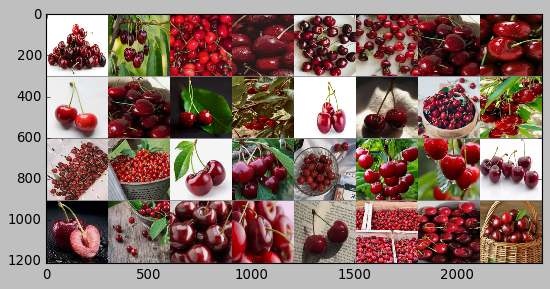

cherry cherry cherry cherry cherry cherry cherry cherry cherry cherry cherry cherry cherry cherry cherry cherry cherry cherry cherry cherry cherry cherry cherry cherry cherry cherry cherry cherry cherry cherry cherry cherry


In [8]:
testiter = iter(testLoader)
images, labels = testiter.next()
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [12]:
# criterion = torch.nn.CrossEntropyLoss()
correct = 0
counter = 0
test_loss = 0.0
torch.cuda.empty_cache()
with torch.no_grad():
    for i, data in tqdm(enumerate(testLoader), total=len(testLoader)):
        counter += 1
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        
        loss = lossFn(outputs, labels)
        test_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        
        correct += (predicted == labels).sum().item()
        
epoch_loss = test_loss / counter
print(f"Loss of the network on the test images: {epoch_loss:.3f}")
print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / len(testLoader.dataset)))

  0%|          | 0/18 [00:00<?, ?it/s]

Loss of the network on the test images: 0.387
Accuracy of the network on the test images: 84 %
